# ipynb for a 2-D CNN for classifying ECGs
Best results found so far used:
    * 3 VCG leads concatenated
    * 200 buffer, 150 shift (looking at QRS -> T lump)
    * Input data chunked into 10000 healthy and 10000 unhealthy samples
    * Peak finder threshold of 0.02 on differentiated and absoluted input data 
    (then it is returned to undiff, unabs data before it is fed in)
    * Trained over 1 epoch.
    * The CNN:
        * Conv with 32 features, map 5x3.
        * 2x2 max pool.
        * Conv 64 features, map 5x3.
        * 2x2 max pool.
        * 1024 neuron dense layer, L2 regularisation with weight_decay=0.001.
        * 50% dropout layer.
        * 2 wide softmax layer.
        * ADAM optimiser with learning_rate=0.00001.
        * Loss function is categorical x-entropy.
        
This gives a result of Sensitivity: 1.0 Specifity: 0.9965 Accuracy: 0.9982 for data taken from the training set (but not trained with).
And Sensitivity: 0.9988 Specifity: 0.9959 Accuracy: 0.9974 on patients it hasn't seen before.

In [2]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import shuffle, randint
from sklearn.utils import shuffle as mutualShuf
import os
import pandas as pd
import sklearn
import datetime
%matplotlib inline

# Import and process data

In [3]:
def importData(filepath):
    ppt = np.genfromtxt(filepath)
    dppt = np.diff(np.transpose(ppt)) 
    print(filepath, "Shape:", dppt[1:16,:].shape)
    return dppt[1:16,:]

pathIll = "./inData/clean_ecg/ill/"
pathHealth = "./inData/clean_ecg/health/"
illLst = []
healthLst = []

for file in os.listdir(pathIll):
    illLst.append(importData(pathIll+file))
for file in os.listdir(pathHealth):
    healthLst.append(importData(pathHealth+file))

./inData/clean_ecg/ill/s0198lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0389lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0411lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0559_re.txt Shape: (15, 120011)
./inData/clean_ecg/ill/s0495_re.txt Shape: (15, 120011)
./inData/clean_ecg/ill/s0339lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0362lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0356lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0409lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0378lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0416lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0348lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0225lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0417lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0375lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0352lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0373lre.txt Shape: (15, 115199)
./inData/clean_ecg/ill/s0235lre.txt Shape: (15, 

In [4]:
print("Outputing Frank leads")
healthPat = np.concatenate((healthLst[:]), axis=1)[12:15]
illPat = np.concatenate((illLst[:]), axis=1)[12:15]
    
print(healthPat.shape, illPat.shape)

Outputing Frank leads
(3, 4652605) (3, 3811191)


In [5]:
def findAbove(arr, threshold, skip):
    """
    Return indices for values above threshhold in array, arr. Keep only first items in sequence.
    """
    inlst = []
    for index, item in enumerate(arr):
        if item >= threshold:
            inlst.append(index)
            
    return inlst[::skip]

def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def getSamples(Arr, indexArr, buffer):
    """
    Get samples for inputting into CNN.
    """
    sampleArr = []

    for index, item in enumerate(indexArr):
        if Arr[0:, item-buffer:item+buffer].shape != (Arr.shape[0], buffer*2):
            pass
        else:
            sampleArr.append(Arr[0:, item-buffer:item+buffer])

    return np.array(sampleArr)

def visualiseData(ecgData, classData, gridSize, axis):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    """
    fig, ax = plt.subplots(gridSize, gridSize, subplot_kw=dict(projection='3d'))
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-ecgData.shape[1])
    k = 0
    if gridSize == 1:
        ax.plot(ecgData[r+k,0], ecgData[r+k,1], ecgData[r+k,2])
    else:
        for i in np.arange(0,gridSize,1):
            for j in np.arange(0,gridSize,1):
                k = k + 1
                ax[i,j].plot(ecgData[r+k,0], ecgData[r+k,1], ecgData[r+k,2])
                if axis == False:
                    ax[i,j].axis("off")
                ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                            size=10, ha='left', va='top')

def undiff(ecgData, buffer):
    """
    Reverse the differentiation done earlier through np.cumsum.
    """
    ecgData = np.array(ecgData)
    ecgData = np.reshape(ecgData, (ecgData.shape[0], ecgData.shape[1], buffer*2))
    for i in np.arange(0,ecgData.shape[0],1):
        for j in np.arange(0,ecgData.shape[1],1):
            ecgData[i,j] = np.cumsum(ecgData[i,j])
    ecgData = np.reshape(ecgData, (ecgData.shape[0], ecgData.shape[1], buffer*2, 1))
    return ecgData            
            
def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

def chunkify(lst,n):
    """ Chunk a list into n chunks of approximately equal size """
    return [ lst[i::n] for i in range(n) ]

def functionTownCat(illArr, healthArr, illThreshold, healthThreshold, skip, shift, buffer, shuffle):
    """
    Return the processed ecgData with the leads concatenated into a 2d array per heartbeat
    and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuffle is true, shuffle data.
    """
    
    illPeakArr = findAbove(np.abs(illArr[0]), illThreshold, skip)
    sampleArrI = getSamples(illArr, np.array(illPeakArr), buffer)
    
    healthPeakArr = findAbove(np.abs(healthArr[0]), healthThreshold, skip)
    sampleArrH = getSamples(healthArr, np.array(healthPeakArr), buffer)
    
    chunkyI = chunkify(sampleArrI, 10000)
    chunkyH = chunkify(sampleArrH , 10000)
    avgI = []
    avgH = []
    
    for i in np.arange(0,len(chunkyI),1):
        avgI.append(np.mean(chunkyI[i], axis=0))
        
    for i in np.arange(0,len(chunkyH),1):
        avgH.append(np.mean(chunkyH[i], axis=0))
    
    sampleArrI = np.array(avgI)
    sampleArrH = np.array(avgH)
    
    print("Total ill samples", len(illPeakArr), ". Compressed to", sampleArrI.shape)
    print("Total healthy samples", len(healthPeakArr), ". Compressed to", sampleArrH.shape)
    
    classData = []
    for i in np.arange(0, sampleArrI.shape[0], 1):
        classData.append(1)
    for i in np.arange(0, sampleArrH.shape[0], 1):
        classData.append(0)
    ecgData = np.concatenate((sampleArrI, sampleArrH), axis=0)
                        
    if shuffle == True:
        classData, ecgData = mutualShuf(np.array(classData), ecgData, random_state=0)    
    
    classDataOH = processClassData(classData)
    ecgData = np.reshape(ecgData, [-1, sampleArrI.shape[1], buffer*2, 1])
    return ecgData, classDataOH, classData

buffer = 300
healthThreshold = 0.02
illThreshold = 0.02
skip = 1
shift = 0
shuf = True

ecgData, classDataOH, classData = functionTownCat(illPat, healthPat, illThreshold, healthThreshold, skip,\
                                               shift, buffer, shuf)
# Reintegrate the found values...
ecgData = undiff(ecgData, buffer)

# Take 20% for testing later:
testData = ecgData[:round(ecgData.shape[0]*0.2)]
trainData = ecgData[round(ecgData.shape[0]*0.2):]
testLabels = classDataOH[:round(ecgData.shape[0]*0.2)]
trainLabels = classDataOH[round(ecgData.shape[0]*0.2):]

Total ill samples 180028 . Compressed to (10000, 3, 600)
Total healthy samples 215821 . Compressed to (10000, 3, 600)


In [ ]:
print(ecgData.shape)
visualiseData(np.reshape(ecgData,(-1,ecgData.shape[1],buffer*2))[:,:], classData, 2, True)
#plt.plot(ecgData[0,0,:]*ecgData[0,1,:])
#plt.savefig("./outData/figures/exampleDataECGundiff.pdf")

In [33]:
print(trainData.shape)

(16000, 3, 600, 1)


# Neural Network

In [32]:
sess = tf.InteractiveSession()
tf.reset_default_graph()
tflearn.initializations.normal()

# ecgData = np.zeros((50,12,400,1)) # If ecgData is not defined
# Input layer:
net = tflearn.layers.core.input_data(shape=[None, buffer*2, buffer*2, buffer*2, 1])

# First layer:
net = tflearn.layers.conv.conv_3d(net, 32, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_3d(net, 2)

# Second layer:
net = tflearn.layers.conv.conv_3d(net, 64, 5, activation="leaky_relu")
net = tflearn.layers.conv.max_pool_3d(net, 2)
net = tflearn.layers.core.flatten(net)

# Fully connected layer 1:
net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

# Dropout layer:
net = tflearn.layers.core.dropout(net, keep_prob=0.5)

# Output layer:
net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                         learning_rate=0.00001)

In [19]:
model = tflearn.DNN(net, tensorboard_verbose=3)
model.fit(trainData, trainLabels, n_epoch=1, show_metric=True)

ValueError: No variables to save

In [10]:
# Save model?
#now = datetime.datetime.now()
#model.save("./outData/models/cleanECG_2dconv_12lead_"+now.isoformat()+"_.tflearn")

# Test accuracy of model(s)
## 20% of training data held back for testing (4000 "heartbeats")

In [9]:
#model.load("./outData/models/cleanECG_undiff_20e_300buff_0shift_2017-02-21T19:20:35.702943_.tflearn")
#model.load("./outData/models/cleanECG_undiff_20e_150buff_2017-02-21T16:15:02.602923_.tflearn")
#model.load("./outData/models/cleanECG_2dconv_12lead_2017-03-08T10:15:17.200943_.tflearn")
#model.load("./outData/models/cleanECG_2dconv_12lead_2017-03-09T18:05:18.655939_.tflearn")

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [10]:
labellst = classData[:round(ecgData.shape[0]*0.2)]
healthTest = []
illTest = []
for index, item in enumerate(labellst):
    if item == 1:
        illTest.append(testData[index])
    if item == 0:
        healthTest.append(testData[index])

healthLabel = np.tile([1,0], (len(healthTest), 1))
illLabel = np.tile([0,1], (len(illTest), 1))
                      
print("Sensitivity:", model.evaluate(np.array(healthTest), healthLabel), "Specifity:",\
    model.evaluate(np.array(illTest), illLabel),\
    "Accuracy:", model.evaluate(testData, testLabels))

Sensitivity: [0.99102691900456774] Specifity: [1.0] Accuracy: [0.99550000000000005]


## What if the model hasn't seen data from the patient? What then?!

In [11]:
tpathIll = "./inData/clean_ecg/testIll/"
tpathHealth = "./inData/clean_ecg/testHealth/"
tillLst = []
thealthLst = []

for file in os.listdir(tpathIll):
    tillLst.append(importData(tpathIll+file))
for file in os.listdir(tpathHealth):
    thealthLst.append(importData(tpathHealth+file))

./inData/clean_ecg/testIll/s0177lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0044lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0088lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0219lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0215lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0174lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0314lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0145lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0133lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0185lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0080lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0124lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0100lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0119lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0131lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0127lre.txt Shape: (15, 115199)
./inData/clean_ecg/testIll/s0095lre.txt 

In [ ]:
if frank == False:
    print("Outputing standard ECG leads...")
    thealth = np.concatenate((thealthLst[:]), axis=1)[0:12]
    till = np.concatenate((tillLst[:]), axis=1)[0:12]

elif frank == True:
    print("Outputing Frank leads...")
    thealth = np.concatenate((thealthLst[:]), axis=1)[12:15]
    till = np.concatenate((tillLst[:]), axis=1)[12:15]
    
print(thealth.shape, till.shape)
  
unseenData, unseenClassOH, unseenClass = functionTownCat(till, thealth, illThreshold, healthThreshold, \
                                                   skip, shift, buffer, True)

Outputing standard ECG leads...
(12, 4788699) (12, 3718367)


In [15]:
# Undifferentiate values
unseenData = undiff(unseenData, buffer)
tillarr, thealtharr = splitData(unseenData, unseenClass)
 
sens = model.evaluate(np.array(thealtharr), np.tile([1,0], (len(thealtharr), 1)))[0]
spec = model.evaluate(np.array(tillarr), np.tile([0,1], (len(tillarr), 1)))[0]
acc = model.evaluate(unseenData, unseenClassOH)[0]
lenh = len(thealtharr)
leni = len(tillarr)

print("Sensitivity:", sens,\
      "Specifity:", spec,\
      "Accuracy:", acc)

Sensitivity: 0.957 Specifity: 0.9767 Accuracy: 0.96685


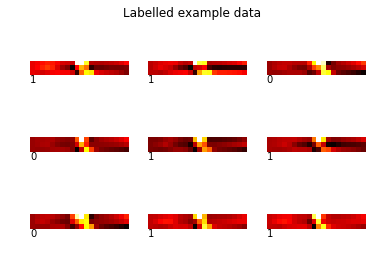

In [37]:
visualiseData(np.reshape(unseenData,(-1,unseenData.shape[1],buffer*2))[:,:,::20], unseenClass, 3, False)